In [ ]:
# For user-defined post processing and plotting functions
include(joinpath(@__DIR__, "..", "..", "utils", "plot_utils.jl"))

overlay_posterior_on_observed (generic function with 1 method)

Welcome to the "how to" of Markov Chain Monte Carlo using Turing. A Julia software package allowing you to fit complex models with ease. 

## Case Study 1: Exponential Growth

We are going to establish an exponential model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! We will read our data from a CSV into a DataFrame. It's also smart to handle any necessary data conversions during this step. You may not need to and that's just fine! It all depends on what you are looking for.

In [ ]:
## Cell 1 ##

using CSV, DataFrames

df = CSV.read("../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells

log_y_obs = log.(y_obs .+ 1e-9)

nothing

Here is the first thing that needs to be done. We will setup the logistic ODE that will adapt to the data. To do this, you will use variables that Turing gives you by 'default'. Let me explain. Notice the 4 parameters being passed in. **du**, **u**, **p**, and **t**. **du** will be the array your functions go in. **u** are you starting states. **p** are your parameters. **t** are your times. Turing and Julia will handle the passing of these under the hood. Just make sure you declare them correctly and remember the order of things. If you have states 1 and 2 then EVERYWHERE you make sure anytime those states are passed they are in that exact order. Same things with your parameters. Lots of things happen under the hood here for you, so things are not always 'explicitly' passed, so make sure when you do pass things your order is always preserved.

**mum**: Growth Rate  
**y**: Initial Value

$$
\frac{dy}{dt} = \mu y
$$

In [ ]:
## Cell 2 ##

function ode(du, u, p, t)
    mum = p[1]
    y = u[1]
    du[1] = mum * y
    return nothing
end

nothing

This is where we start to use Turing. We declare the function to be probabilistic model named **fit_ode** using the **@model** tag. The inputs are as follows.

**log_y_obs**: Our log transformed observed data.
**times**: The times at which the ODE is evaluated.
**prob**: The prebuilt ODE.

Next come where we assign out priors. Choosing priors is an interesting combination of art and science. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. For $\mu$ we chose a truncatednormal prior. This says, we believe there is a normal distribution about some **x**, however, it cannot be above **y** or below **z**. For **N0**, we chose a lognormal distribution. This says we believe our value is around some **x** given a normalesque strictly positive distribution. For **sigma**, we chose a halfnormal distribution. This is usually used for your error or standard deviation. This is saying we know we can not have negative error, and we believe the error will be closer to 0 than farther away, however, we are not explicitly capping it off in the positive direction.

<img src="../prior_figures/priors_c1p1.png" width="300"/>

The next part are instructions on how to solve the ODE. The following is what gets passed into **solve**.

**prob**: The prebuilt ODE.  
**Tsit5()**: An ODE solver. What solver you use is generally up to you.  
**u0**: State priors.  
**p**: Parameter Priors.    
**saveat**: all the times from the observed times.  

**note**: See how when you're passing in values to this julia function there are both **,** and **;**? In julia this is to mark the difference between positional arguments (before **;**) and keyword arguments (after **;**).

The final part of the model is getting the likelihood (or fit if you prefer) of the model to the observed data. It's a bit layered here so we'll break it down part by part.

**log.(Array(sol)[1, :] .+ 1e-9)**: **sol** is the solver output. We force it into an array using **Array** and grab the first row using the **[1, :]** indexing. That indexing will match whatever state you want. If you have multiple states then row 1, 2, 3... will correspond to the order that the states are passed into **u0**. Last we put the output on a log scale. Note that seeing a **.** connected to a mathematical operation makes it an element-wise array operation. The **.+ 1e-9** is an array addition of a value inconsequentially near 0 so there are no log(0) errors.   
**log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))**: For simplicity this will be a little hand wavey. At this step you have the log scaled y_pred and the sigma distribution. Give those to **arraydist(Normal.())** and it will tell the model how well it's guess was. In other words, this line is the model saying each observed log value is normal around the predicted log-value with standard deviation **sigma**. Ensure the variable preceding the **~** here is the same as the one passed into **fit_ode**.


In [ ]:
## Cell 3 ##

using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [N0], p = mum,  
                saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

nothing

This block is where we declare the ODE with some starter values, call the model, and run the sampling.

To start,

**u0**: Initial state value(s). Make the inital value(s) from the observed data.  
**p**: Initial parameter value(s). Make these a value in the specified range of the prior you declared. Here we chose the center.  
**tspan**:  first and last values from your observed times.  
**prob**: The prebuild ODE.

Next is the call to run the sampling. Here are what the arguments mean.

**model**: The model created above.  
**NUTS(1000, .95)**: This is telling you to use the NUTS sampler. 1000 is the amount of 'warm up' iterations it will do under the hood. .95 is the acceptance rate of the 'improved' solutions.   
**MCMCSerial()**: Tells the solver to run the chains sequentially. 
**1000**: number of posterior samples to be generated.
**3**: number of chains.
**progress**: either hides or shows the progress bar. Up to you.

Here we aren't going to run the sampling for time purposes. Instead we have the chain saved VIA Julia serialization and will call it to show the postprocessing. 

In [ ]:
## Cell 4 ##

using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

model    = fit_ode(log_y_obs, times, prob)
# chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)

using Serialization
chain = deserialize("chains/case_study_1_p1.jls")::Chains  # load

nothing

To interpret the output we have some user-defined postprocessing and plotting functions. They are in our GitHub repo.

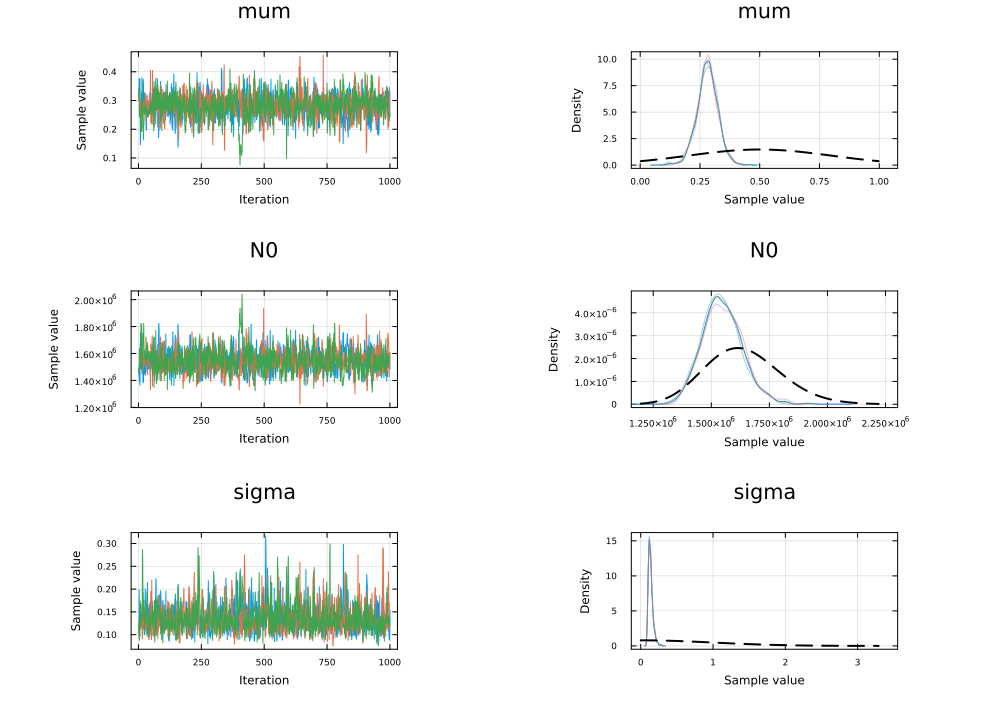

In [7]:
priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

order = [:mum, :N0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

Now we interpret the results. Remember the ODE's from before.

$$
\frac{dy}{dt} = \mu y
$$

Take note of x-axis values at the peaks of the PDFs and the variables they represent. The x-axis values at those peaks are what the model found to be the optimal value for the equation. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space well enough. 



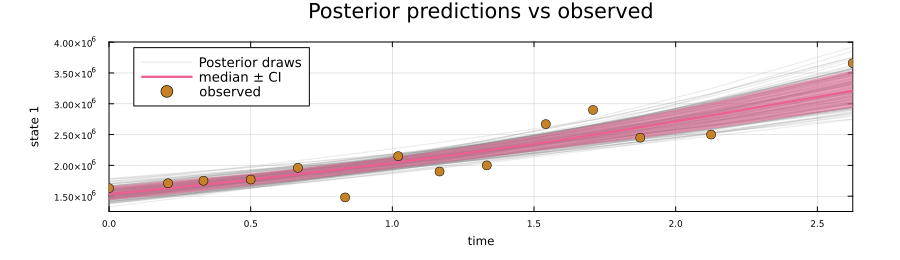

In [8]:
init_syms = [:N0]
param_syms = [:mum]
t_obs = times
y_obs = y_obs

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    legend=:topleft,
    logy=false
)
display(plt)

This plot is showing how well the range of estimated chains fit the observed data. 

**CONGRATULATIONS!** you just ran you first MCMC!

## Case Study 1: Exponential Growth and Death

Now on to a more complex model. We will be using the same data as before.


In [ ]:
## Cell 5 ##

using CSV, DataFrames

df = CSV.read("../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells

nothing

$$
\frac{dy}{dt} = (\mu - \delta)\, y
$$

Here we are simply subtracting a **delta** from **mu** so that **delta** can simulate death. In short, we don't always need death (or something else comperable) data. We can simply make our ODE expressive about the data!

In [ ]:
## Cell 6 ##

function ode(du, u, p, t)
    mum = p[1] 
    delta = p[2]
    y = u[1]
    du[1] = (mum - delta) * y
    return nothing
end

nothing

Here is the model. Everything here should make sense. If something is confusing see the explination above cell 4. Still note that we have two likelihoods at the bottom since we are estimating two states.

In [ ]:
## Cell 7 ##

using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    delta ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [N0], p = [mum, delta],  
                saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

nothing

Everything here is the same as before! See explination above cell 5 if you forgot something.

In [ ]:
## Cell 8 ##

using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5, 0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_y_obs = log.(y_obs .+ 1e-9)
model    = fit_ode(log_y_obs, times, prob)
# chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)

using Serialization
chain = deserialize("chains/case_study_1_p2.jls")::Chains 

nothing

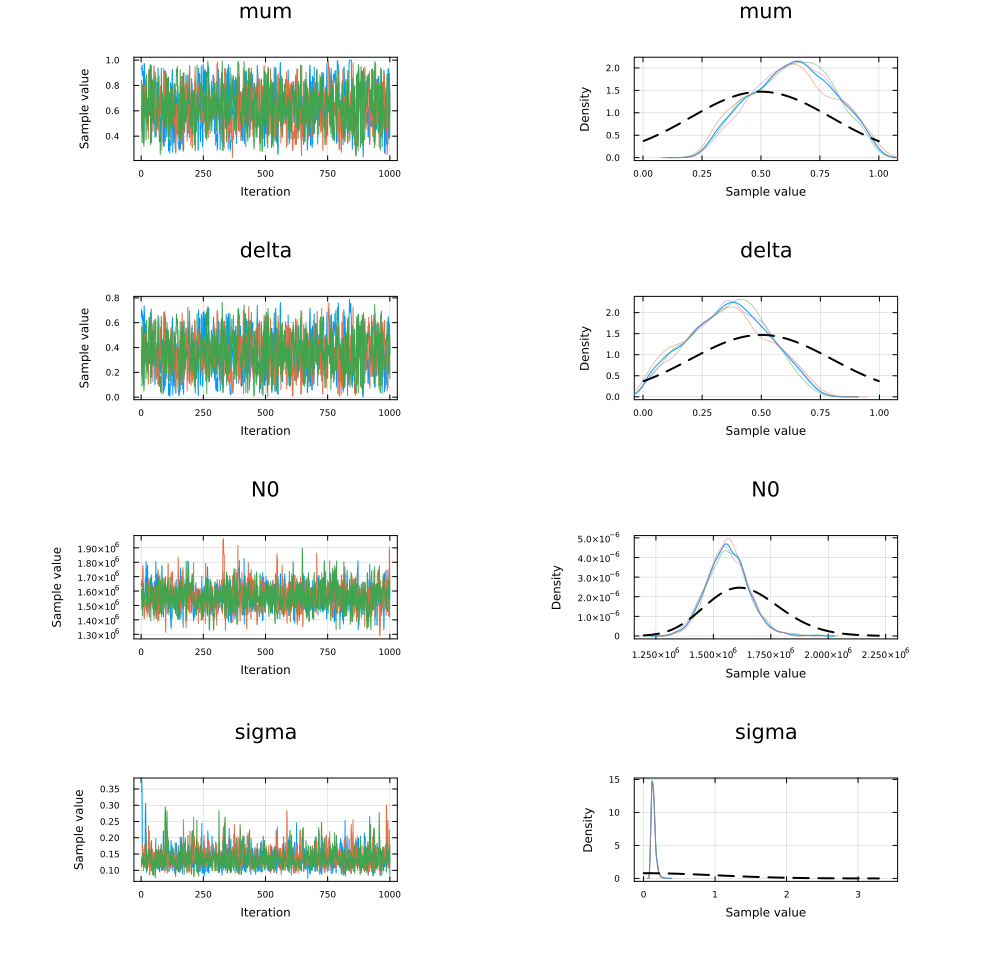

In [ ]:
priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :delta => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

order = [:mum, :delta, :N0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

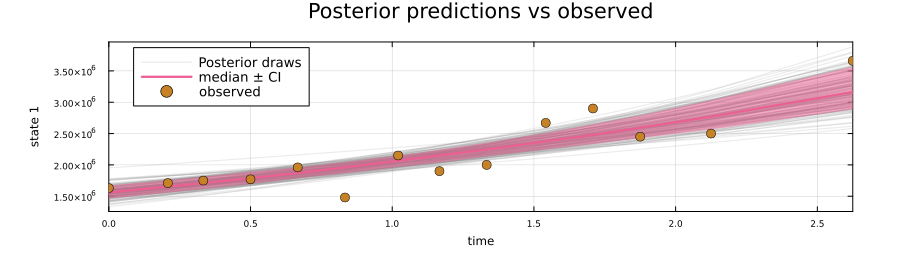

In [15]:
init_syms = [:N0]
param_syms = [:mum, :delta]
y_obs = y_obs
t_obs = times

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    legend=:topleft,
    logy=false
)
display(plt)

## The End